# SC1015 DSAI Mini Project
## Part 4: Clustering
---
This is the section where we cluster our `conv_vars_df`. We use the new dataset with reduced dimensions to do this. 

We have chosen the **Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)** clustering algorithm for the purpose of our clustering. 

The reasons we have chosen this particular clustering algorithm are:
1. This is a density based clustering algorithm which means it does not need the specification of the number of clusters. Essentially, this algorithm will not *force* any point into a cluster. Instead, points which do not really belong to any cluster are labeled "noise". This is clearly useful for us since we are doing anomaly detection (outlier/noise detection).
2. Because this is density based, the shape of our data does not matter which is useful since we are working with high dimensional data and it is not possible for us to visualize and understand what kind of shapes our data might have. 
3. With a non-hierarchical DBSCAN, we would have to hyperparameter tune for `epsilon` which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. This is a difficult parameter to tune. We would also have to tune `min_samples` (the number of samples in a neighborhood for a point to be considered as a core point) along with this. HDBSCAN removes the need for us to tune `epsilon`. Instead we only work with `min_samples` and `min_cluster_size` (the minimum size a final cluster can be). `min_cluster_size` is relatively easy to tune. So, essentially we would only have to tune `min_samples`
4. Because HDBSCAN is a hierarchical clustering algorithm even if we have a high dimensional data, we can use dendrograms to somewhat visualize the clusters and make inferences.
    -   Note: this is one of the reasons `min_cluster_size` is easy to tune.

More details on HDBSCAN and its parameters are presented in the rest of this notebook.

**Question:** Does Being Unconventional Determine Success?

**Dataset:** [Stack Overflow Developer Survey 2020 on Kaggle](https://www.kaggle.com/aitzaz/stack-overflow-developer-survey-2020)

## Table of Contents:
1. [Clustering with Random Parameters](#1\.-Clustering-with-Random-Parameters)
2. [Hyperparameter Tuning Using `GridSearchCV`](#2\.-Hyperparameter-Tuning-Using-GridSearchCV)
3. [Plotting DBCV vs. `min_samples`](#3\.-Plotting-DBCV-vs\.-min_samples)
4. [Clustering with New Parameters](#4\.-Clustering-with-New-Parameters)
5. [Increasing `min_cluster_size` to `30`](#5\.-Increasing-min_cluster_size-to-30)
6. [Creating DataFrame With Clustered Points](#6\.-Creating-DataFrame-With-Clustered-Points)
7. [Converting DataFrame to Pickle File](#7\.-Converting-DataFrame-to-Pickle-File)

In [3]:
import pandas as pd
import numpy as np

import hdbscan

import logging
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

In [4]:
conv_vars_df = pd.read_pickle('conv_vars_less_dims.pickle')
conv_vars_df

OpSys           PlatformWorkedWith                                \
             0         1                  0         1         2         3    
0      0.488916  0.968879          -0.261067 -0.289234 -0.105833 -0.086375   
1     -0.664356 -0.075039          -0.138209  0.419785  0.302513 -0.307976   
2     -0.664356 -0.075039          -0.020325  0.122572 -0.659488 -0.073063   
3     -0.664356 -0.075039          -0.360463 -0.005268 -0.033489  0.174872   
4     -0.664356 -0.075039          -0.551867 -0.011362  0.003455 -0.022148   
...         ...       ...                ...       ...       ...       ...   
19357 -0.664356 -0.075039          -0.422903  0.233372  0.501220  0.194008   
19358  0.713143 -0.637515           0.486336 -0.579728 -0.063059 -0.069444   
19359 -0.664356 -0.075039          -0.551867 -0.011362  0.003455 -0.022148   
19360  0.713143 -0.637515          -0.261067 -0.289234 -0.105833 -0.086375   
19361 -0.664356 -0.075039          -0.478035  0.150148 -0.043226 -0.033937   

                                    DatabaseWorkedWith  ...  \
             4         5         6                  0   ...   
0     -0.135445  0.160893 -0.120863           0.182597  ...   
1     -0.140970  0.071127  0.086634          -0.558953  ...   
2      0.118488  0.110507 -0.420980           0.209126  ...   
3      0.138054  0.185212 -0.183355          -0.413959  ...   
4      0.038836  0.037289  0.000606          -0.347170  ...   
...         ...       ...       ...                ...  ...   
19357  0.007494 -0.059742 -0.174096           0.010040  ...   
19358 -0.305045 -0.030197  0.145388           1.178607  ...   
19359  0.038836  0.037289  0.000606          -0.558953  ...   
19360 -0.135445  0.160893 -0.120863           0.053521  ...   
19361  0.364704 -0.147806  0.149542          -0.265805  ...   

      LanguageWorkedWith                     WebframeWorkedWith            \
                      8         9         10                 0         1    
0               0.117175 -0.048144 -0.119423           0.101257 -0.480765   
1              -0.065854 -0.063722 -0.102583           0.061347 -0.275087   
2              -0.099066  0.002143 -0.070101           0.224844  0.067606   
3              -0.072042  0.002242  0.049784           0.022019  0.014207   
4              -0.069495 -0.151268  0.095711          -0.378472  0.176205   
...                  ...       ...       ...                ...       ...   
19357           0.046253  0.322042  0.608192           0.245165  0.073108   
19358           0.065744 -0.181526 -0.003053           0.103926 -0.331398   
19359           0.022599  0.052966 -0.094406          -0.334295 -0.249411   
19360          -0.100159 -0.122908  0.148564           0.397010  0.119778   
19361          -0.043003  0.111281  0.053115          -0.092883 -0.148014   

                                                         
             2         3         4         5         6   
0      0.307525  0.110485  0.106287 -0.071057  0.104100  
1      0.392402  0.117162  0.147623 -0.012150 -0.025452  
2     -0.159046  0.518323  0.337956 -0.036581  0.151075  
3      0.035772  0.076387 -0.191776 -0.310875 -0.146662  
4     -0.224730  0.383069  0.022765 -0.044310  0.091775  
...         ...       ...       ...       ...       ...  
19357 -0.568642 -0.579787  0.843856 -0.241702  0.246295  
19358 -0.107945 -0.184561 -0.160079  0.012911  0.099058  
19359  0.090823 -0.137421 -0.089177  0.032127  0.054622  
19360  0.016496  0.178240  0.508680  0.685097 -0.621225  
19361  0.196761 -0.066560 -0.193068  0.065242 -0.083301  

[19362 rows x 42 columns]

### 1. Clustering with Random Parameters

We will now try to use HDBSCAN to cluster our dataset. For this section, we will be using random parameters. We have chosen: \
`min_samples = 15` \
`min_cluster_size = 55`

Here: \
`min_samples` refers to the number of samples in a neighborhood for a point to be considered as a core point of a cluster \
`min_cluster_size` refers to the minimum size a final cluster can be

The algorithm generates a dendrogram which is a diagram representing the hierarchy of clusters. The `min_cluster_size` determines which branches to consider in the same cluster while `min_samples` is more influential on deciding how the dendrogram itself forms. The dendrogram here is called `condensed_tree_plot_` because it is a condensed version of the dendrogram which helps in visualizing large volume of data more easily. 

Although since clustering is an unsupervised algorithm, it cannot be easily checked for "goodness of fit", in the case of density-based clustering, there exists a metric called the Density-Based Clustering Validation (DBCV). It ranges from -1 to 1 (higher value meaning a better clustering solution). The `relative_validity_` attribute outputs this DBCV score of our model.

In [5]:
hdb = hdbscan.HDBSCAN(min_samples=15, min_cluster_size=55, gen_min_span_tree=True)

In [6]:
hdb.fit(conv_vars_df)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=55, min_samples=15)

<AxesSubplot:ylabel='$\\lambda$ value'>

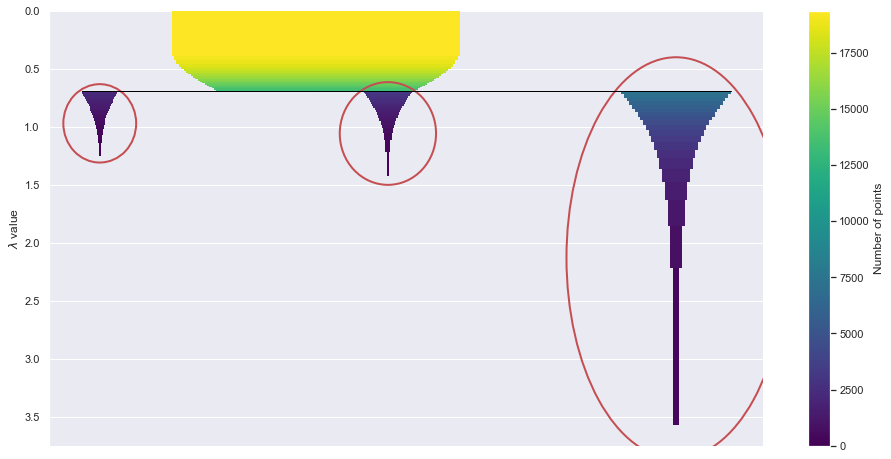

In [7]:
# this is the dendogram diagram with the red circles representing the clusters selected by the algorithm
plt.figure(figsize=(16,8))
hdb.condensed_tree_.plot(select_clusters=True)

In [8]:
hdb.relative_validity_

4.808856507041543e-05

#### We noticed that the DBCV score is quite low for these parameters. We changed this and tried once again

Now,\
`min_samples = 15`\
`min_cluster_size = 10`

In [9]:
hdb = hdbscan.HDBSCAN(min_samples=15, min_cluster_size=10, gen_min_span_tree=True)

In [10]:
hdb.fit(conv_vars_df)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=10, min_samples=15)

/Users/ardnep/miniconda3/lib/python3.8/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<AxesSubplot:ylabel='$\\lambda$ value'>

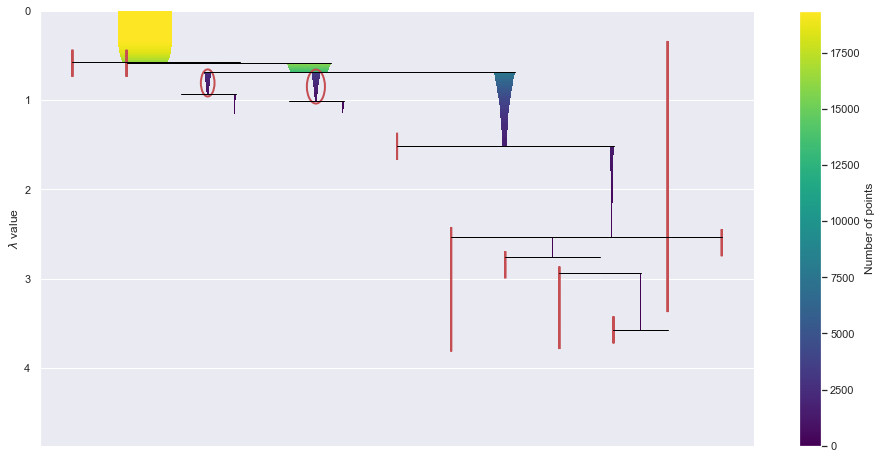

In [11]:
plt.figure(figsize=(16,8))
hdb.condensed_tree_.plot(select_clusters=True)

In [12]:
hdb.relative_validity_

0.0016088310239301155

### 2. Hyperparameter Tuning Using `GridSearchCV`

Now, we try to properly find parameters that optimize our clustering solution using the DBCV score. We will try to change the parameters `min_samples` and `min_cluster_size` and see which combinations of these give us the best DBCV score.

To achieve this, we use the `GridSearchCV` algorithm and only check with a subset of our original dataset because of computational limitations. 

In [11]:
# random sample a subset of dataset (10,000 rows)
subset = conv_vars_df.sample(n=10000)

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(subset)

logging.captureWarnings(True)

# set the combinations of parameters to try
param_dist = {'min_samples': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'min_cluster_size':[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}

# create the DBCV metric
validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better=True)

# run the GridSearchCV Algorithm
grid_search = GridSearchCV(hdb, param_grid=param_dist, n_jobs=-1, scoring=validity_scorer)
grid_search.fit(subset)

# print the best parameter
print(grid_search.best_params_)

# print the DBCV score with the best parameters
print(grid_search.best_estimator_.relative_validity_)

{'min_cluster_size': 5, 'min_samples': 5}
0.03862644977016001


We noticed that DBCV score is still not that high even while using `GridSearchCV` to check accross a range of parameters. This is likely due to using only a subset of the original dataset and also because the `GridSearchCV` algorithm also splits the data for cross validation purposes. This is not neccessary for clustering unlike for other tasks such as classification which usually involve a train set and a separate test set. The reason we still chose to use `GridSearchCV` was for the convenience it provides in checking accross a range of parameters. Additionally, we wanted to see what kinds of results we would obtain regardless. 

### 3. Plotting DBCV vs. `min_samples`

As previously mentioned, `GridSearchCV` did not yield desirable results. So, we tried to instead manually change `min_samples` only while keeping `min_cluster_size = 10` (arbitrarily chosen) to see what kinds of results we get.

To achieve this, we created a function and plotted DBCV vs. `min_samples`.

In [12]:
# this is for making a progress bar
from IPython.display import clear_output

def get_min_samples_validity(data, start=1, end=50):
    '''
    Varies value of min_samples from start to end (step=1) and returns the relative validities
    
    Parameters:
    data: data (type: array-like)
    start: start value for min_samples (type: int)
    end: end value for min_samples (type: int)
    
    Returns:
    Tuple with relative_validities dictionary and n_clusters list
    '''
    relative_validities = []
    n_clusters = []
    
    # print a progress bar 
    print('|'+(' '*(end-start))+'|')
    
    # run HDBSCAN on the different min_samples depending on range specified
    for i in range(start, end+1):
        clusterrer = hdbscan.HDBSCAN(min_samples=i, gen_min_span_tree=True, min_cluster_size=10)
        clusterrer.fit(data)
        
        # save the number of clusters formed with the current min_samples
        n_clusters.append(max(clusterrer.labels_)+1)
        
        # save the relative validity (DBCV score) for the current min_samples
        relative_validities.append(clusterrer.relative_validity_)
        
        # update the progress bar
        clear_output()
        print('|'+('*'*(i+1))+(' '*(end-start-i))+'|')
        
    
    return relative_validities, n_clusters

In [13]:
relative_validities, n_clusters = get_min_samples_validity(conv_vars_df)

|***************************************************|


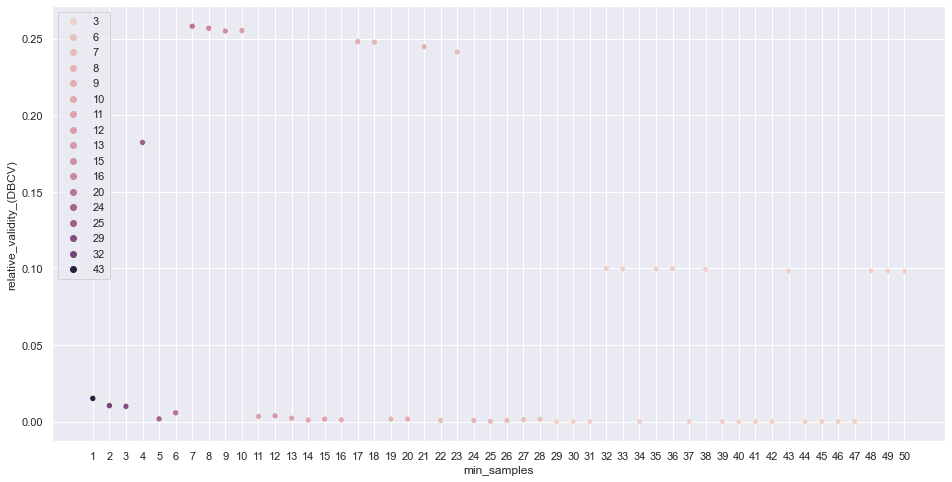

In [14]:
plt.figure(figsize=(16,8))
sb.scatterplot(x=np.arange(1, 51, dtype=int), y=relative_validities, hue=n_clusters, legend='full')
plt.xticks(np.arange(1, 51, dtype=int))
plt.xlabel('min_samples')
plt.ylabel('relative_validity_(DBCV)')
plt.savefig('dbcv_min_samples_1.png')

In [30]:
relative_validities[7-1]

0.2581259315631292

We noticed with the help of this plot that `min_samples = 7` with `min_cluster_size = 10` seems to be a good choice as it gives a `relative_validity_` approximately equal to  `0.26`.

### 4. Clustering with New Parameters

Now, we use the parameters from the previous section to cluster our data.

In [13]:
hdb = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=10, gen_min_span_tree=True)

In [14]:
hdb.fit(conv_vars_df)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=10, min_samples=7)

/Users/ardnep/miniconda3/lib/python3.8/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<AxesSubplot:ylabel='$\\lambda$ value'>

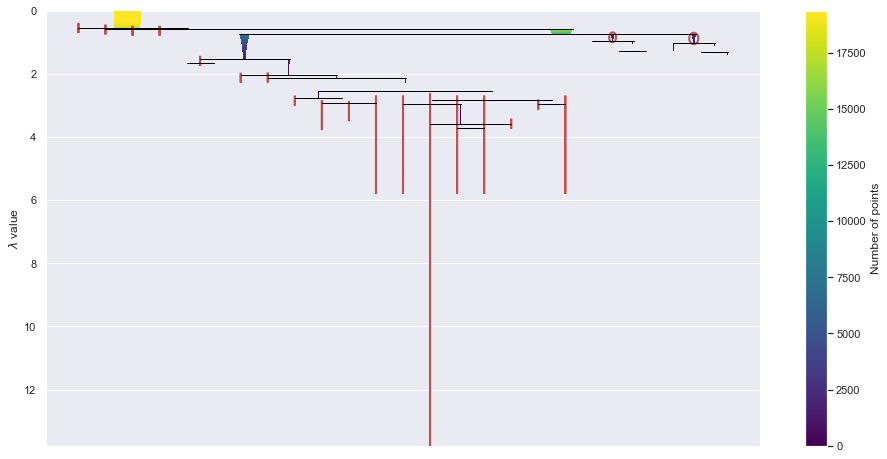

In [15]:
plt.figure(figsize=(16,8))
hdb.condensed_tree_.plot(select_clusters=True)

In [16]:
hdb.relative_validity_

0.2581259315631292

In [17]:
# print the number of outliers (noise points)
len([val for val in hdb.labels_ if val == -1])

13202

With this approach, however, we increase the DBCV but run into another issue which is that most of our data is being labelled noise (`13202` of `19362`). We checked the probabilies of our non-noise points belonging to their cluster and realized that there were a lot of data points which with probability `1` of belonging to their cluster. This could suggest that the `min_cluster_size` is too small.

/Users/ardnep/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

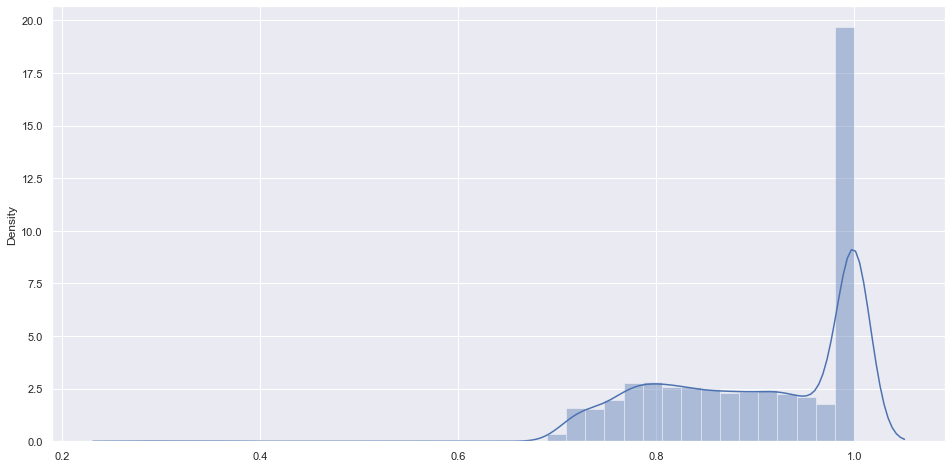

In [18]:
# probabilities of points lying in their cluster
plt.figure(figsize=(16,8))
sb.distplot([val for val in hdb.probabilities_ if val])

### 5. Increasing `min_cluster_size` to `30`

Becaue of the aforementioned issue, we decided to instead increase the `min_cluster_size` to `30` to consider more points into our clusters.

In [19]:
hdb = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=30, gen_min_span_tree=True)

In [20]:
hdb.fit(conv_vars_df)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=30, min_samples=7)

<AxesSubplot:ylabel='$\\lambda$ value'>

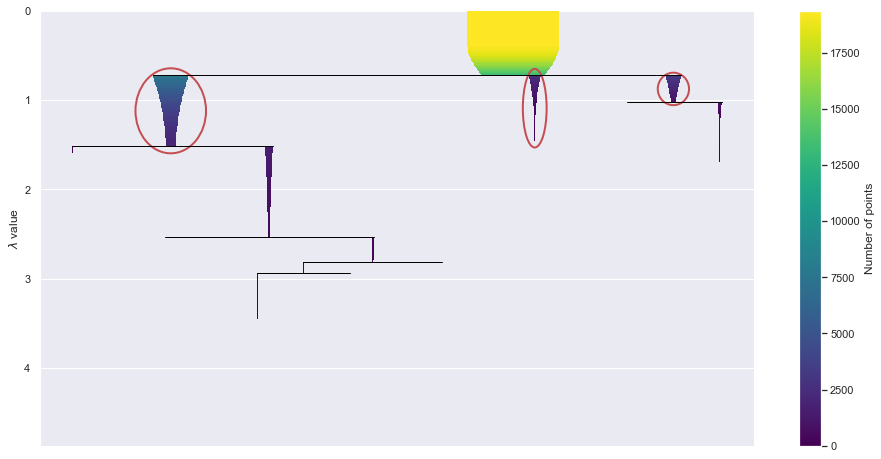

In [21]:
plt.figure(figsize=(16,8))
hdb.condensed_tree_.plot(select_clusters=True)

In [22]:
hdb.relative_validity_

0.00011362952312039105

In [23]:
# print the number of outliers (noise points)
len([val for val in hdb.labels_ if val == -1])

6206

/Users/ardnep/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

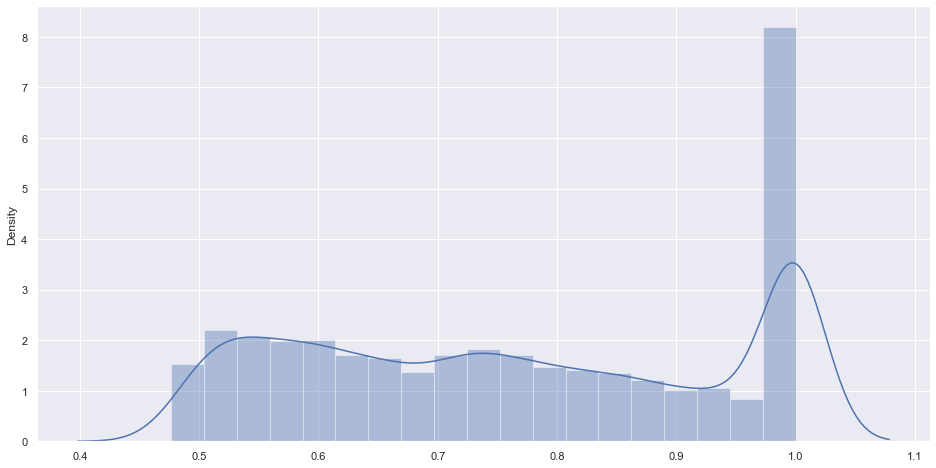

In [24]:
plt.figure(figsize=(16,8))
sb.distplot([val for val in hdb.probabilities_ if val])

Now we can notice that with the increase in cluster size, we have only `6206` noise points and a total of `3` clusters. 

### 6. Creating DataFrame With Clustered Points

Using the previous clustering solution with:

`min_samples = 7`

`min_cluster_size = 30`

No. of Clusters = `3`

No. of Outliers = `6206` (of `19362`)

we create a DataFrame with the information about which point belongs to which cluster. Here, `-1` represents noise points

In [25]:
conv_vars_clustered_df = pd.DataFrame(hdb.labels_, columns=['Cluster'])
conv_vars_clustered_df

,Cluster
0,2
1,1
2,-1
3,1
4,1
...,...
19357,-1
19358,-1
19359,1
19360,0


### 7. Converting DataFrame to Pickle File

In [26]:
conv_vars_clustered_df.to_pickle('conv_vars_clustered.pickle')